In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [7]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [8]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount
0,2014,1,88
229447,2011,1,10
156483,2012,1,50
76159,2013,1,8
76160,2013,1,16


In [9]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()



400.963857957 std
442.363262216 mean
338.0 median
2500.0 max mult
0.00314465408805 min mult
1600.0 98%
559.0 q3
199.0 q1
48.0 02%
360.0 iqr
-341.0 min_q 1099.0 max_q


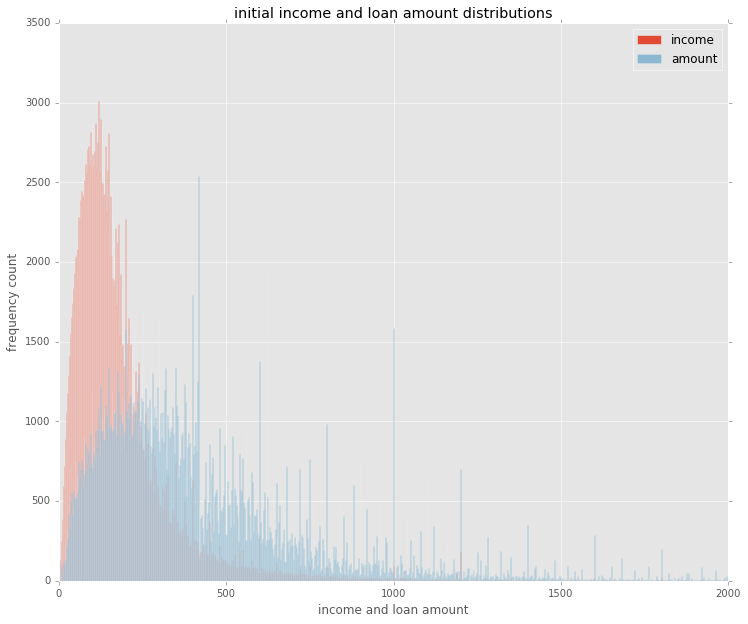

In [10]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5 * iqr #potential lower bound for quality
max_q = q3 + 1.5 * iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz

name 0 to 10
std 222.319323449
mean 162.265745008
median 102.0
max_mult 2500.0
min_mult 0.25
q98 784.0
q02 15.0
q75 180.0
q25 56.0
iqr 124.0
min_q -130.0
max_q 366.0
count of loans 651
pct of total loans 0.221977474912


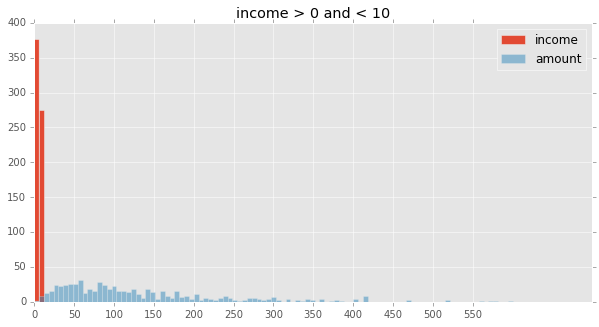

name 10 to 30
std 100.272681345
mean 106.198390093
median 85.0
max_mult 156.25
min_mult 0.0526315789474
q98 356.0
q02 19.0
q75 128.5
q25 52.0
iqr 76.5
min_q -62.75
max_q 243.25
count of loans 8075
pct of total loans 2.7534072349


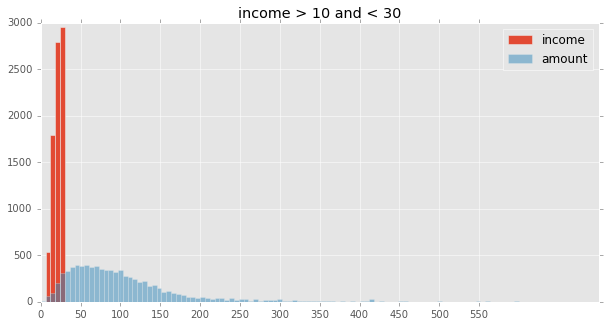

name 30 to 50
std 94.7922196407
mean 141.636993798
median 131.0
max_mult 100.885714286
min_mult 0.030303030303
q98 345.0
q02 24.0
q75 186.0
q25 79.0
iqr 107.0
min_q -81.5
max_q 346.5
count of loans 16446
pct of total loans 5.60774432014


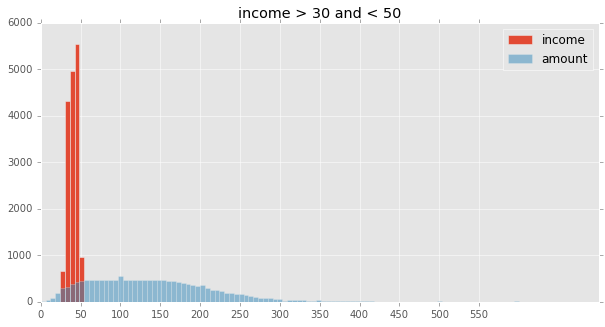

name 50 to 70
std 143.264585158
mean 189.551268067
median 180.0
max_mult 237.857142857
min_mult 0.0645161290323
q98 400.0
q02 35.0
q75 254.0
q25 111.0
iqr 143.0
min_q -103.5
max_q 468.5
count of loans 22002
pct of total loans 7.50222488944


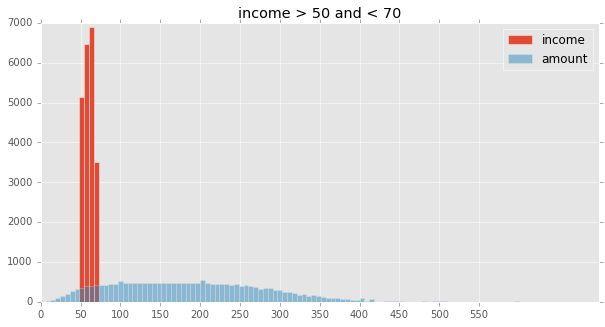

name 70 to 90
std 120.111004068
mean 232.375769534
median 223.0
max_mult 40.0
min_mult 0.0958904109589
q98 480.0
q02 45.0
q75 311.0
q25 141.0
iqr 170.0
min_q -114.0
max_q 566.0
count of loans 25340
pct of total loans 8.6404135396


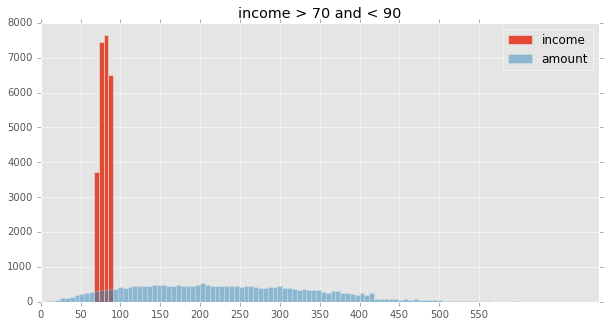

name 90 to 110
std 136.143377491
mean 272.288776797
median 260.0
max_mult 21.2765957447
min_mult 0.0747663551402
q98 566.0
q02 56.0
q75 359.0
q25 169.0
iqr 190.0
min_q -116.0
max_q 644.0
count of loans 26962
pct of total loans 9.19348184115


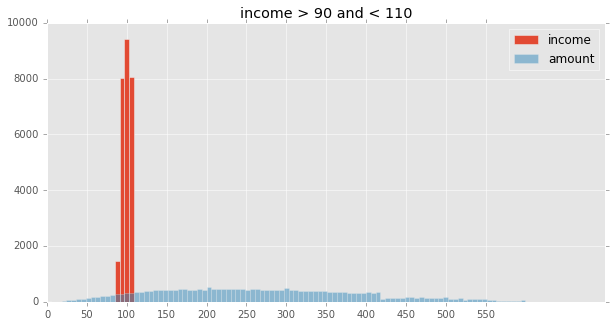

name 110 to 130
std 153.358120975
mean 314.738817385
median 298.0
max_mult 22.7272727273
min_mult 0.0545454545455
q98 642.0
q02 71.0
q75 405.0
q25 200.0
iqr 205.0
min_q -107.5
max_q 712.5
count of loans 26805
pct of total loans 9.13994810296


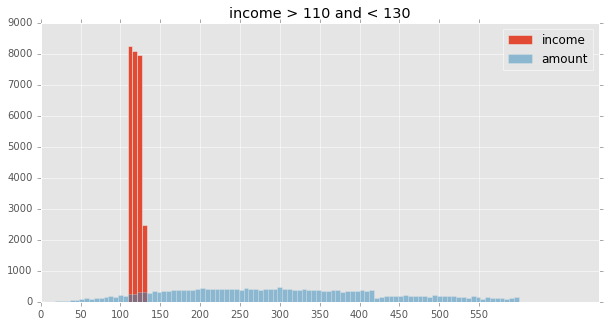

name 130 to 150
std 167.957619016
mean 353.200274459
median 332.0
max_mult 20.273381295
min_mult 0.0555555555556
q98 729.0
q02 85.0
q75 461.0
q25 230.0
iqr 231.0
min_q -116.5
max_q 807.5
count of loans 24776
pct of total loans 8.44810125719


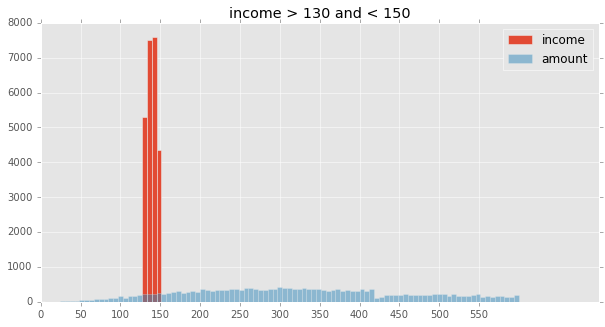

name 150 to 170
std 187.580396471
mean 393.352881136
median 365.0
max_mult 15.5844155844
min_mult 0.0533333333333
q98 840.0
q02 98.0
q75 512.0
q25 258.0
iqr 254.0
min_q -123.0
max_q 893.0
count of loans 21554
pct of total loans 7.34946619702


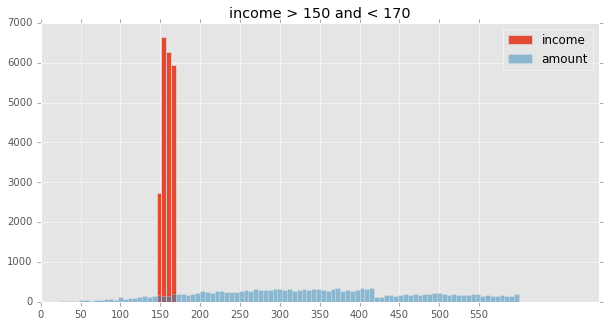

name 170 to 190
std 206.384593501
mean 432.663821478
median 396.0
max_mult 21.4827586207
min_mult 0.0454545454545
q98 938.52
q02 114.0
q75 556.0
q25 285.0
iqr 271.0
min_q -121.5
max_q 962.5
count of loans 17925
pct of total loans 6.11205259264


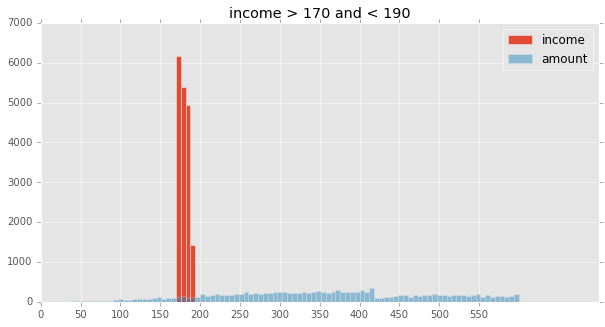

name 190 to 210
std 226.192745796
mean 474.238088953
median 437.0
max_mult 14.2718446602
min_mult 0.0384615384615
q98 1040.0
q02 122.0
q75 606.0
q25 310.0
iqr 296.0
min_q -134.0
max_q 1050.0
count of loans 15154
pct of total loans 5.16719916256


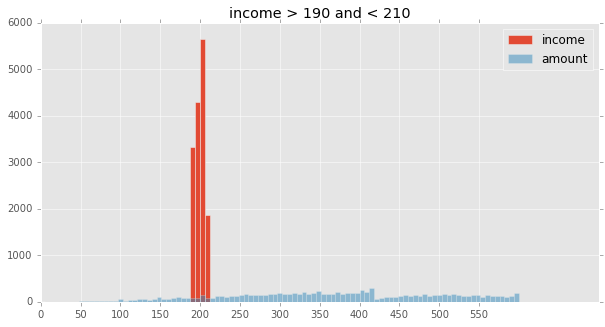

name 210 to 230
std 244.729866818
mean 519.173466972
median 490.0
max_mult 10.8597285068
min_mult 0.134529147982
q98 1116.6
q02 133.4
q75 656.0
q25 339.0
iqr 317.0
min_q -136.5
max_q 1131.5
count of loans 12671
pct of total loans 4.32054774903


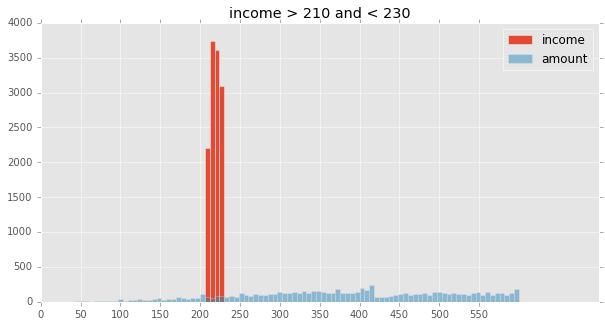

name 230 to 250
std 266.750702782
mean 561.367414312
median 532.0
max_mult 16.743697479
min_mult 0.127659574468
q98 1208.04
q02 142.0
q75 707.0
q25 367.0
iqr 340.0
min_q -143.0
max_q 1217.0
count of loans 10299
pct of total loans 3.51174502938


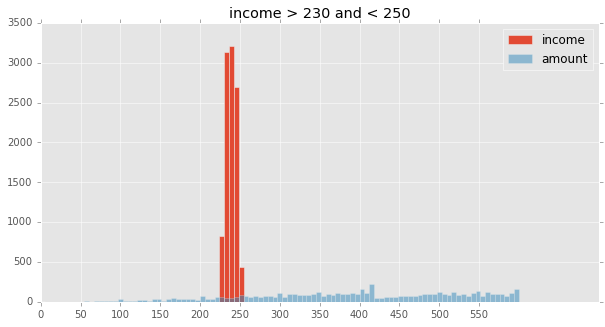

name 250 to 270
std 287.850266947
mean 605.644466756
median 571.0
max_mult 8.0
min_mult 0.0965250965251
q98 1320.0
q02 150.0
q75 760.0
q25 392.0
iqr 368.0
min_q -160.0
max_q 1312.0
count of loans 8964
pct of total loans 3.05653776515


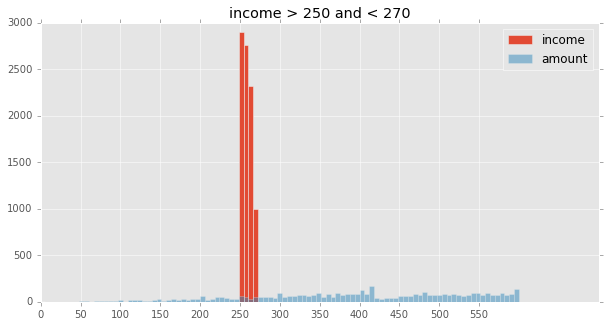

name 270 to 290
std 317.128490141
mean 648.979946335
median 604.0
max_mult 14.6210526316
min_mult 0.0280701754386
q98 1434.4
q02 160.0
q75 829.0
q25 413.0
iqr 416.0
min_q -211.0
max_q 1453.0
count of loans 7081
pct of total loans 2.41447388611


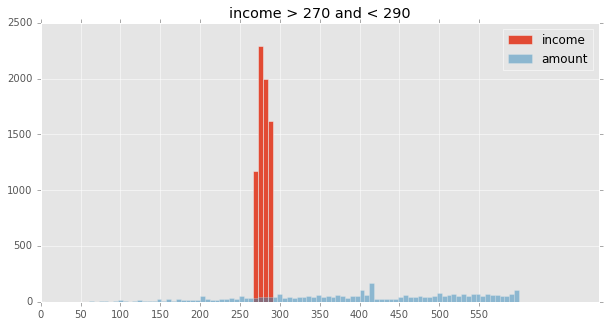

name 290 to 310
std 335.347255924
mean 694.099419916
median 644.0
max_mult 7.70169491525
min_mult 0.0271186440678
q98 1500.0
q02 160.1
q75 900.0
q25 435.0
iqr 465.0
min_q -262.5
max_q 1597.5
count of loans 6206
pct of total loans 2.11611706499


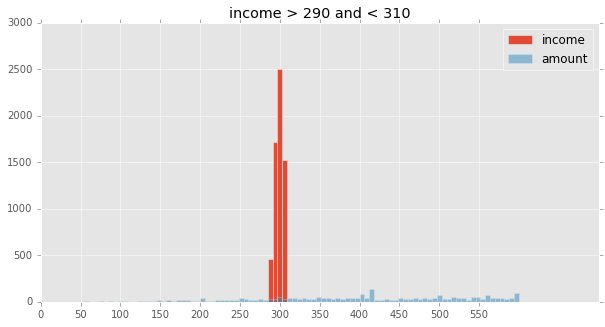

name 310 to 330
std 350.796021623
mean 730.603796204
median 680.0
max_mult 7.86392405063
min_mult 0.0253968253968
q98 1556.92
q02 175.0
q75 950.0
q25 475.0
iqr 475.0
min_q -237.5
max_q 1662.5
count of loans 5005
pct of total loans 1.7066010168


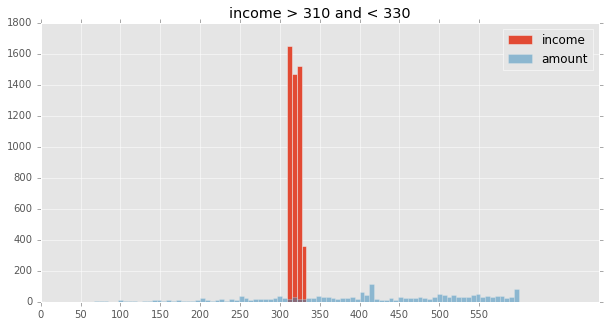

name 330 to 350
std 371.360850774
mean 768.647557328
median 704.0
max_mult 7.25757575758
min_mult 0.14450867052
q98 1702.34
q02 190.22
q75 1000.0
q25 500.0
iqr 500.0
min_q -250.0
max_q 1750.0
count of loans 4012
pct of total loans 1.36800864723


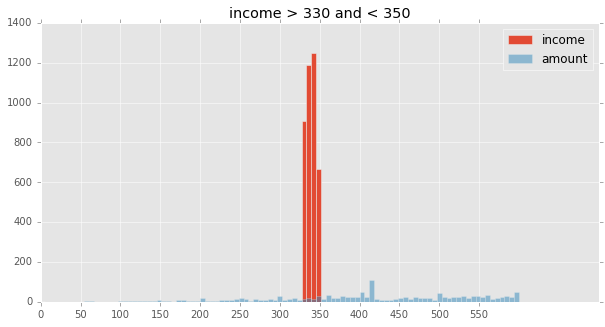

name 350 to 370
std 394.399614397
mean 789.92
median 725.0
max_mult 8.5
min_mult 0.139275766017
q98 1762.52
q02 164.48
q75 1022.0
q25 505.0
iqr 517.0
min_q -270.5
max_q 1797.5
count of loans 3825
pct of total loans 1.30424553232


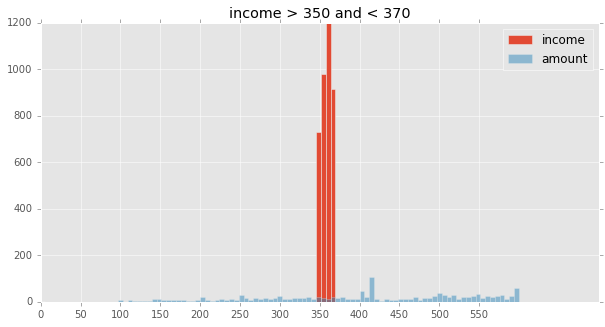

name 370 to 390
std 414.187675859
mean 829.983601181
median 750.0
max_mult 8.78378378378
min_mult 0.0616966580977
q98 1840.0
q02 192.0
q75 1095.0
q25 521.0
iqr 574.0
min_q -340.0
max_q 1956.0
count of loans 3049
pct of total loans 1.03964565439


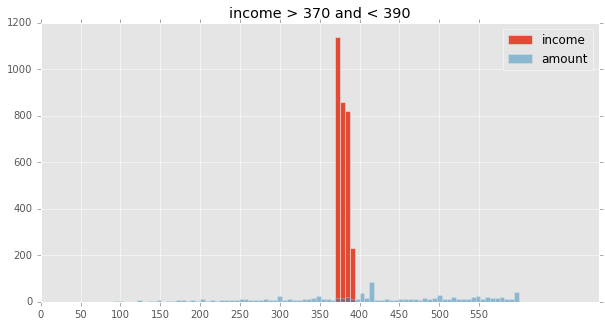

name 390 to 410
std 447.187363632
mean 855.548573492
median 784.0
max_mult 16.4141414141
min_mult 0.05
q98 1927.68
q02 200.0
q75 1120.0
q25 532.0
iqr 588.0
min_q -350.0
max_q 2002.0
count of loans 2769
pct of total loans 0.944171471632


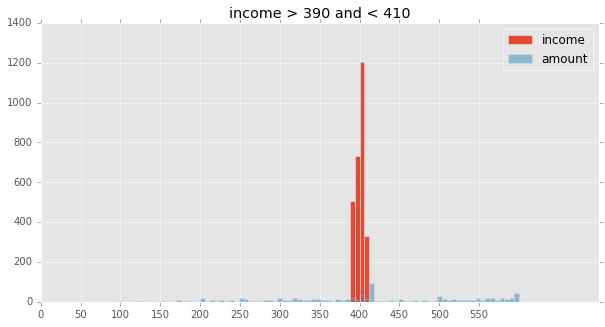

name 410 to 430
std 444.346591691
mean 895.733454216
median 832.0
max_mult 6.26463700234
min_mult 0.0571428571429
q98 1986.8
q02 204.5
q75 1194.5
q25 560.0
iqr 634.5
min_q -391.75
max_q 2146.25
count of loans 2206
pct of total loans 0.752200168444


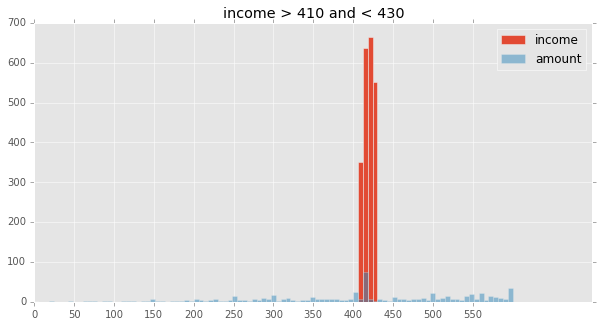

name 430 to 450
std 477.352280901
mean 913.129884425
median 860.0
max_mult 11.7511520737
min_mult 0.0925925925926
q98 2000.0
q02 187.96
q75 1200.0
q25 548.0
iqr 652.0
min_q -430.0
max_q 2178.0
count of loans 1817
pct of total loans 0.619559250255


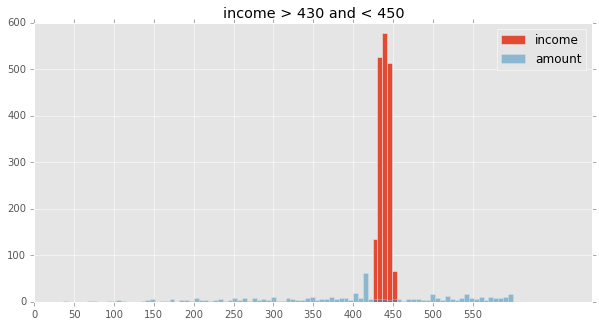

name 450 to 470
std 479.371032904
mean 929.844101956
median 863.0
max_mult 8.44086021505
min_mult 0.0789473684211
q98 2000.0
q02 200.0
q75 1236.0
q25 576.0
iqr 660.0
min_q -414.0
max_q 2226.0
count of loans 1687
pct of total loans 0.575231951117


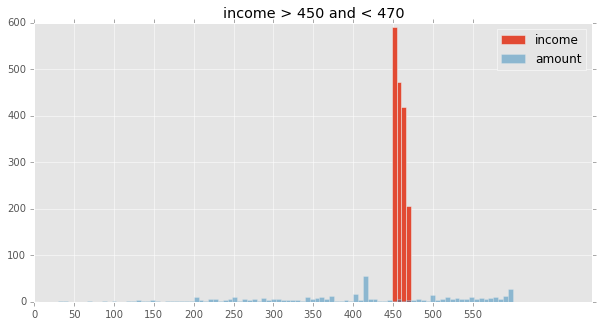

name 470 to 490
std 505.096435969
mean 965.31472764
median 899.0
max_mult 6.96428571429
min_mult 0.145833333333
q98 2000.0
q02 188.32
q75 1299.0
q25 580.0
iqr 719.0
min_q -498.5
max_q 2377.5
count of loans 1487
pct of total loans 0.50703610629


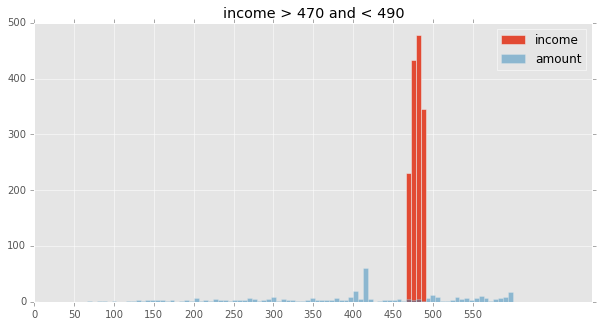

In [11]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 10
bin_step = 20
pct_of_loans = OrderedDict({})
while bin_max < 501:
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100
    
    for key, value in bin_stats.items():
        print(key,value)
    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 600 #set maximum x axis value
    xsteps= 100 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']